# Lab 8: AutoML

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install --quiet openml
    !pip install --quiet gama

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import tensorflow as tf

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Exercise 1: Using GAMA

### Installation

In this exercise we will use AutoML tool [GAMA](https://github.com/PGijsbers/gama/).
The exercise is self-contained, but if you want to know more the documentation is found [here](https://pgijsbers.github.io/gama/develop/).
First, make sure GAMA is installed and/or check the right version is installed:

In [2]:
#!pip install --quiet gama
# Note: On MacOS, you may also need to install openblas, e.g. with `brew install openblas`

In [3]:
from packaging import version
import gama
if version.parse(gama.__version__) < version.parse("20.1.0"):
    print("GAMA is outdated. Please update now!")
else:
    print("OK. You may continue :)")

OK. You may continue :)


*note*:
> GAMA is under active development. Parts of the interface are still subject to change. We are also using small time budgets because the lab only lasts two hours. For that reason some of the results may be affected more than usual by the randomness inherent to evolutionary search.

### Standard use case on NO<sub>2</sub> data

In lab session 1, we tested several models the predict **NO<sub>2</sub>** levels.
Here we will use GAMA automatically find a pipeline for this task.
First we have to fetch the data from OpenML, and split it into a train and test set:

In [4]:
from sklearn.model_selection import train_test_split
no2 = oml.datasets.get_dataset(547)
X, y, _, _ = no2.get_data(target=no2.default_target_attribute, dataset_format='dataframe');
X = X.drop('day',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

We can then import and use GAMA just like a scikit-learn classifier or regressor:

In [5]:
import logging
from gama import GamaClassifier, GamaRegressor
automl = GamaRegressor(
    max_total_time=60, # in seconds
    n_jobs=1,  # one subprocess
    scoring='r2',  # metric to optimize for
    verbosity=logging.WARNING,  # to get printed updates about search progress
    output_directory="gama_log",  # name for a log file to record search output in
)

#### Exercise 1.1
Starting AutoML is now as simple as calling `fit` with the training data. You can use the `score` function to get the model's score on the test set. Using GAMA, fit a model to the data and report the score.

In [6]:
# Exercise 1.1: Call fit and score
automl.fit(X_train, y_train)

/Users/jvanscho/miniforge3/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/jvanscho/miniforge3/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
automl.score(X_test, y_test)

0.18004587099500413

How does the score compare to the maximum of `0.4796` found in lab 1?
It's likely better. Because the dataset is so small, even in one minute time GAMA can evaluate many pipelines.
GAMA also considers more (and different) models than those from lab 1.

The number of pipelines that have been evaluated should've been printed as cell output.
But we can also have a closer look at which pipelines have been evaluated.
We do this by parsing the log GAMA created (filename set by `keep_analysis_log`) with the builtin `GamaReport` parser:

In [8]:
def transform_evaluations(df):
    """ The GamaReport was initially developed for use within GAMA tooling.
    For this reason it contains some hard to interpret, useless or internal data.
    For clarity, we filter this out for you.
    """
    df = df.drop(['id', 'length_cummax', 'relative_end'], axis=1)
    df['length'] = -df['length']
    return df

In [9]:
from gama.logging.GamaReport import GamaReport
report = GamaReport(log_directory="gama_log")
evaluations = transform_evaluations(report.evaluations)
evaluations.sample(5).sort_values(by='n')  # Show 5 random samples from the dataframe, but sort them by order of n.

preprocessing default after 0.0009s.

search AsyncEA after 53.0824s.

postprocess BestFitPostProcessing after 0.1582s.



,pid,start,duration,t_process,score,pipeline,error,parent0,parent1,origin,n,r2,length,r2_cummax
19593,79783,2022-02-02 22:24:07.645673,0 days 00:00:00.000124931,0.000132,"(-inf, -2)","GradientBoostingRegressor(Nystroem(data, Nystr...",<class 'TypeError'> check_cv() takes from 0 to...,4aa674e3-e797-490a-b405-e125558a5f88,NaN,mut_insert,19593,-inf,2.0,-inf
22148,79783,2022-02-02 22:24:10.818902,0 days 00:00:00.000092983,0.000101,"(-inf, -2)","GradientBoostingRegressor(MaxAbsScaler(data), ...",<class 'TypeError'> check_cv() takes from 0 to...,dab8c779-2661-4110-acc3-fe463080337e,NaN,mut_insert,22148,-inf,2.0,-inf
42800,79783,2022-02-02 22:24:35.461106,0 days 00:00:00.000218153,0.000224,"(-inf, -2)","GradientBoostingRegressor(SelectFwe(data, Sele...",<class 'TypeError'> check_cv() takes from 0 to...,27903398-5556-469f-9c6c-e23f8593484d,NaN,mut_insert,42800,-inf,2.0,-inf
42865,79783,2022-02-02 22:24:35.538670,0 days 00:00:00.000098944,0.000103,"(-inf, -2)","GradientBoostingRegressor(MaxAbsScaler(data), ...",<class 'TypeError'> check_cv() takes from 0 to...,018364fe-f35c-4c82-a383-bdccbcf7ce43,NaN,mut_insert,42865,-inf,2.0,-inf
43600,79783,2022-02-02 22:24:36.388697,0 days 00:00:00.000099182,0.000103,"(-inf, -1)","GradientBoostingRegressor(data, GradientBoosti...",<class 'TypeError'> check_cv() takes from 0 to...,ec5cc934-0d3b-4fc8-95ab-2d3a17f2b338,NaN,mut_replace_terminal,43600,-inf,1.0,-inf


This dataframe has the following columns:
 - n: the n-th pipeline to be evaluated in search
 - start: start time of the evaluation
 - duration: the time it took to evaluate the model (in seconds)
 - r2: the r2 score of the pipeline (based on 5-fold cross-validation on the training data)
 - length: the number of steps in the pipeline times (i.e., length 2 means one preprocessing step and one estimator).
 - pipeline: the pipeline (more info below)
 - r2_cummax: the maximum r2 score found at evaluation `n`

#### Exercise 1.2:
Find the best pipeline of each length from the `evaluations` dataframe (or one of the best, in case of a tie).

In [10]:
# Exercise 1.2: Find the best pipeline of each length
evaluations.sort_values('r2', ascending=False).drop_duplicates(['length'])

,pid,start,duration,t_process,score,pipeline,error,parent0,parent1,origin,n,r2,length,r2_cummax
0,79783,2022-02-02 22:23:44.711950,0 days 00:00:00.000200987,0.000197,"(-inf, -3)",GradientBoostingRegressor(StandardScaler(MaxAb...,<class 'TypeError'> check_cv() takes from 0 to...,NaN,NaN,new,0,-inf,3.0,-inf
29319,79783,2022-02-02 22:24:19.406984,0 days 00:00:00.000093937,0.000100,"(-inf, -1)","GradientBoostingRegressor(data, GradientBoosti...",<class 'TypeError'> check_cv() takes from 0 to...,b664ffba-b8e4-4989-b205-0717fbcb3995,NaN,mut_replace_terminal,29319,-inf,1.0,-inf
29311,79783,2022-02-02 22:24:19.398273,0 days 00:00:00.000107050,0.000112,"(-inf, -2)","ExtraTreesRegressor(FastICA(data, FastICA.tol=...",<class 'TypeError'> check_cv() takes from 0 to...,f5292317-1ea0-42a9-8ee3-505328a6bd9c,NaN,mut_insert,29311,-inf,2.0,-inf
88,79783,2022-02-02 22:23:44.748849,0 days 00:00:00.000212908,0.000219,"(-inf, -4)",DecisionTreeRegressor(StandardScaler(Normalize...,<class 'TypeError'> check_cv() takes from 0 to...,d4670a36-d05a-445d-9d17-18dd92f205b2,NaN,mut_insert,88,-inf,4.0,-inf


To visualize the progress of search, plot:
 - The `r2` score for each evaluation as a function of `n`, preferably only for those evaluations with an `r2` score of at least 0.
 - The maximum `r2` score as a function of `n`

<AxesSubplot:xlabel='n'>

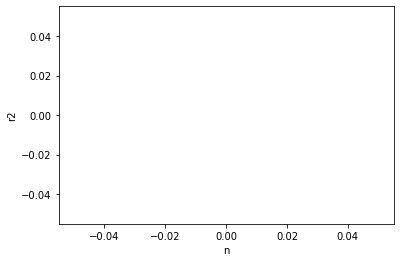

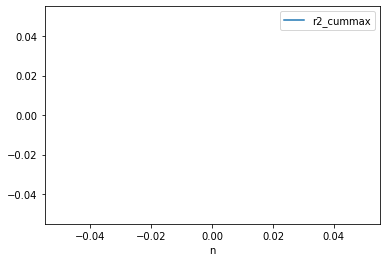

In [11]:
evaluations[evaluations['r2'] > 0].plot.scatter(x='n', y='r2')
evaluations.plot.line(x='n', y='r2_cummax')

### Automatic Ensembles on Covertype

Next we will take a look at a classification problem, and change the AutoML pipeline.

#### Exercise 1.3:
Download the covertype dataset (id: 180) that we saw in lab 3.
First take a stratified subsample of 50% of the data (using `train_test_split`).
Then split that data into a train and test set (50%/50%). 
The train and test sets are now both 25% of the total data.

Initialize a GamaClassifier, similarly to how the GamaRegressor was initialized, but:
 - specify the maximum runtime to at least 3 minutes,
 - set `n_jobs` to 2,
 - set the metric to accuracy,
 - specify a different log name,

Then start search (`fit`) and evaluate the model on the test data (`score`).
Take a short break once it's all running, or ask us a question about the lecture! :)

In [12]:
##### Exercise 1.3: Split the data and run GAMA
trees = oml.datasets.get_dataset(180)
X,y,_,_ = trees.get_data(target=trees.default_target_attribute, dataset_format='dataframe')
X_sub, _, y_sub, _ = train_test_split(X, y, stratify=y, train_size=0.5)
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, stratify=y_sub, train_size=0.5)

In [13]:
automl = GamaClassifier(
    max_total_time=60,
    n_jobs=2,
    scoring='accuracy',
    verbosity=logging.INFO,  # to get printed updates about search progress
    output_directory="gama_log2",  # name for a log file to record search output in
)

Using GAMA version 20.2.1.
INIT:GamaClassifier(scoring=accuracy,regularize_length=True,max_pipeline_length=None,random_state=None,max_total_time=180,max_eval_time=None,n_jobs=2,max_memory_mb=None,verbosity=20,search=AsyncEA(),post_processing=BestFitPostProcessing(),output_directory=gama_log2,store=logs)


In [ ]:
automl.fit(X_train, y_train)

START: preprocessing default
STOP: preprocessing default after 0.0864s.
START: search AsyncEA


/Users/jvanscho/miniforge3/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Starting EA with new population.


/Users/jvanscho/miniforge3/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/jvanscho/miniforge3/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
automl.score(X_test, y_test)

How did the model perform? In lab 3 we had about 80% accuracy after tuning the number of trees in the RandomForest. How does this model compare?

The covertype dataset is quite large, and three minutes is not much time. For this reason we downsampled such that our training set contained only 25% of the original data. In our experience with these constraints, we find that GAMA can produce models with 80% accuracy, but it's also possible to see worse results. With more time we could search longer and evaluate more models on more of the data.

#### Exercise 1.4

Up to this point GAMA has been using the best found pipeline to make predictions on the test data.
However, we saw that constructing ensembles of models can be a useful tool to gain additional performance.
GAMA can be configured to automatically build an ensemble from the models it found during search. To do this you should initialize GAMA with the `post_processing_method` specified:

In [ ]:
from gama.postprocessing import EnsemblePostProcessing

automl_with_ensemble = GamaClassifier(
    max_total_time=60,
    n_jobs=2,
    verbosity=logging.INFO,
    output_directory="gama_log3",
    scoring='accuracy',
    post_processing=EnsemblePostProcessing(),  # Specify to build an ensemble after search
)

Again, start search and record the test set score:

In [ ]:
##### Exercise 1.4
automl_with_ensemble.fit(X_train, y_train)

In [ ]:
score = automl_with_ensemble.score(X_test, y_test)
print("ensemble score: {:.4f}".format(score))

#### Exercise 1.5
Note that this run was independent from the previous run. This means it might have found better or worse pipelines than last search. We cannot compare the performance of this ensemble directly to the previous best score. Run the code cell below to see how the single best pipeline would have scored *this* run:

In [ ]:
# Currently post-hoc switching of post-processing method is not supported directly.
# We work around this:
from sklearn.metrics import log_loss

best, = automl_with_ensemble._evaluation_library.n_best(1)
best_pipeline = best.individual.pipeline
best_pipeline.fit(X_train, y_train)
test_score = best_pipeline.score(X_test, y_test)
print("train score: {:.3f}, test score: {:.3f}".format(best.score[0], test_score))

In this case, did it improve the performance? Was the improvement big?

Normally the ensemble should perform better, though the benefit can be very marginal.
GAMA creates an Ensemble through weighting votes of pipelines evaluated in search (for the interested, the precise procedure is described in [Caruana et al. (2004)](https://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml04.icdm06long.pdf)).
In the scenario and constraints we have set up just now, creating a good ensemble is hard.
Can you think of some reason(s) why?

> Type your answer in this markdown cell.

Solution:
> ...

### Image Recognition with AutoML

> *note*: If you are running out of time, or are experiencing errors below, ignore the coding assigment. We are aware that in some scenarios GAMA halts on this example.

#### Exercise 1.6
AutoML is still not (yet) a one-tool-fits-all solution.
GAMA was designed to deal with tabular data.
Last lab session you trained ConvNets to classify images in the CIFAR dataset.
The very first model already had at least 60% accuracy, the best model had ~83% accuracy.
We will now compare those results to GAMA:
 - download the CIFAR-10 dataset from OpenML (dataset id: 40926)
 - split the data into a train and test set (80%/20%)
 - run GAMA optimizing for accuracy, with n_jobs=1 and (at least) 5 minutes of runtime

Results will vary wildly.
Running it a few times can give scores ranging from ~10% accuracy to ~35% accuracy. 
More time will lead to better results, but it will not approach ConvNet levels of performance.
Why do you think this is?

> Type your answer in this markdown cell.

Solution:
> ...

## Exercise 2: Other AutoML tools
There are AutoML tools that are specifically designed to automatically learn neural network architectures. For example [AutoKeras](https://autokeras.com/) (Texas A&M University), [AutoGluon](https://autogluon.mxnet.io/) (commercial, Amazon), and [Cloud AutoML](https://cloud.google.com/automl) (commercial, Google). If you are eager, do go and compare your own ConvNet to these AutoML systems instead!